<a href="https://colab.research.google.com/github/naoya1110/DL_Lecture_202107/blob/main/Chapter09_UdonAI_Callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 09: UdonAI Callback
深層学習モデルを学習させる際にCallbackと呼ばれる機能を使って学習をコントロールしましょう。


## 準備

### パッケージのインポート
必要なライブラリをインポートしましょう。

In [1]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(precision=3,  suppress=True)
import seaborn as sns
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.math import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# TensorFlowのバージョンを確認
print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.5.0


### うどん店名のリストを作成

In [2]:
udonya_list = ["nagata-in-kanoka", "udon-bakaichidai", "yamagoe", "gamou", "hinode-seimenjo",
                      "ippuku", "moriya", "yoshiya", "sakaeda", "yamadaya"]

udonya_list

['nagata-in-kanoka',
 'udon-bakaichidai',
 'yamagoe',
 'gamou',
 'hinode-seimenjo',
 'ippuku',
 'moriya',
 'yoshiya',
 'sakaeda',
 'yamadaya']

## データの準備

### Googleドライブのマウント

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


googleドライブ内の`DL_Lecture_202107`ディレクトリを作業ディレクトリ`working_dir`として設定します。

In [4]:
working_dir = "/content/drive/MyDrive/DL_Lecture_202107"

### データの読み込み
Chapter07で作成したデータセット`udon10_dataset.npz`を読み込みます。

In [5]:
dataset_name = "udon10_dataset.npz"
dataset_path = os.path.join(working_dir, dataset_name)

data = np.load(dataset_path) 

trainX = data["trainX"].astype("float32")
trainY = data["trainY"]
validX = data["validX"].astype("float32")
validY = data["validY"]
testX = data["testX"].astype("float32")

### 読み込んだデータのshapeを確認

In [6]:
print("Data Shape")
print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("validX:", validX.shape)
print("validY:", validY.shape)
print("testX:", testX.shape)

Data Shape
trainX: (10000, 128, 128, 3)
trainY: (10000,)
validX: (500, 128, 128, 3)
validY: (500,)
testX: (500, 128, 128, 3)


### trainY, validYをonehotベクトル形式に変換

In [7]:
trainY_onehot = to_categorical(trainY)
validY_onehot = to_categorical(validY)

### 学習に使用するデータのshapeを確認

In [8]:
print("Data shapes")
print("trainX:", trainX.shape)
print("trainY_onehot:", trainY_onehot.shape)
print("validX:", validX.shape)
print("validY_onehot:", validY_onehot.shape)
print("testX:", testX.shape)

Data shapes
trainX: (10000, 128, 128, 3)
trainY_onehot: (10000, 10)
validX: (500, 128, 128, 3)
validY_onehot: (500, 10)
testX: (500, 128, 128, 3)


## 学習
モデルを構築し学習させます。callbackを使って学習経過をコントロールします。

### モデルの構築
モデルの構造やハイパーパラメータは適宜調整してください。



In [9]:
# モデルの初期化
model = Sequential()

# 入力層
model.add(InputLayer(input_shape=(128,128,3))) 

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# ドロップアウト
model.add(Dropout(rate=0.2))

model.add(Dense(units=128, activation="relu"))

# ドロップアウト
model.add(Dropout(rate=0.2))

# 出力層，全結合層
model.add(Dense(units=10, activation="softmax"))

# 構築したモデルを可視化して確認
# plot_model(model, show_shapes=True)

構築したモデルは次の方法でも確認できます。この方法では，学習させるパラメータの数を確認することもできます。

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1

### モデルのコンパイル

In [11]:
model.compile(
                loss="categorical_crossentropy", 
                optimizer="adam",
                metrics=["accuracy"]
            )

### Callbackの設定
ここでは次の3つのcallbackを使用します。
* ReduceLROnPlateau
* ModelCheckpoint
* EarlyStopping


**ReduceLROnPlateau**は学習が停滞している場合に学習率(Learning Rate)を自動的に下げるためものです。次のように設定すると3エポック連続してval_lossが改善しなかった場合、学習率を1/2にします。

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              factor=0.5,
                              lr_min = 1E-7,
                              verbose=1
                             )

**ModelCheckpoint**は学習途中のモデルを保存するためのものです。次のように設定するとval_lossが改善されるたびに自動的にそのモデルを保存します。

In [13]:
model_path = os.path.join(working_dir, "UdonAI_best_model.h5")

modelcheckpoint = ModelCheckpoint(filepath=model_path,
                              monitor='val_loss',
                              verbose=1, 
                              save_best_only=True,
                              mode="auto",
                             )

**EarlyStopping**はモデルの学習が進まなくなった場合、事前に設定したエポック数より前に学習を早期終了するためのものです。次のように設定すると10エポック連続してval_lossが改善されなかった場合に学習が早期終了します。

In [14]:
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              mode='auto',
                              verbose=1
                             )

### モデルの学習（トレーニング）

準備したreduce_lr, modelcheckpoint, earlystoppingをcallbacksとしてモデルを学習させます。earlystoppingの効果がわかるようにepochsは大幅に増やして100にしておきましょう。


In [15]:
history = model.fit(
                    trainX, trainY_onehot,
                    batch_size=64,
                    epochs=100,
                    validation_data=(validX, validY_onehot),
                    shuffle=True,
                    verbose=1,
                    callbacks = [reduce_lr, modelcheckpoint, earlystopping]
                   )

Epoch 1/100
157/157 [==============================] - 41s 51ms/step - loss: 2.0768 - accuracy: 0.2291 - val_loss: 1.7715 - val_accuracy: 0.3940

Epoch 00001: val_loss improved from inf to 1.77155, saving model to /content/drive/MyDrive/DL_Lecture_202107/UdonAI_best_model.h5
Epoch 2/100
157/157 [==============================] - 7s 44ms/step - loss: 1.7731 - accuracy: 0.3734 - val_loss: 1.5618 - val_accuracy: 0.4780

Epoch 00002: val_loss improved from 1.77155 to 1.56178, saving model to /content/drive/MyDrive/DL_Lecture_202107/UdonAI_best_model.h5
Epoch 3/100
157/157 [==============================] - 7s 45ms/step - loss: 1.5515 - accuracy: 0.4603 - val_loss: 1.3500 - val_accuracy: 0.5220

Epoch 00003: val_loss improved from 1.56178 to 1.35002, saving model to /content/drive/MyDrive/DL_Lecture_202107/UdonAI_best_model.h5
Epoch 4/100
157/157 [==============================] - 7s 45ms/step - loss: 1.3507 - accuracy: 0.5331 - val_loss: 1.2271 - val_accuracy: 0.5840

Epoch 00004: val_loss

### 学習経過の確認

Text(0, 0.5, 'Accuracy & Loss')

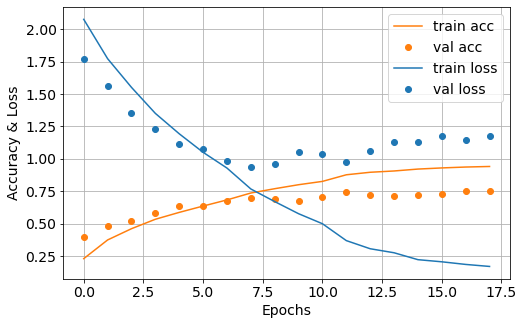

In [16]:
plt.figure(figsize=(8,5))
plt.rcParams["font.size"]=14

epoch = history.epoch
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.plot(epoch, train_acc, label="train acc", c="#ff7f0e")
plt.plot(epoch, val_acc, marker="o", lw=0, label="val acc", c="#ff7f0e")

plt.plot(epoch, train_loss, label="train loss", c="#1f77b4")
plt.plot(epoch, val_loss, marker="o", lw=0, label="val loss", c="#1f77b4")

plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")

## 学習済みモデルの評価（検証用データを利用）

### 学習済みモデルの読み込み

In [17]:
model = load_model(model_path)

### すべての検証用データに対してうどん店を推論

In [18]:
predY_valid_onehot = model.predict(validX)
predY_valid = np.argmax(predY_valid_onehot, axis=1)

### 推論結果の一部を可視化
学習済みモデルを使ってvalidXのデータから推論した結果の一部を表示してみましょう。

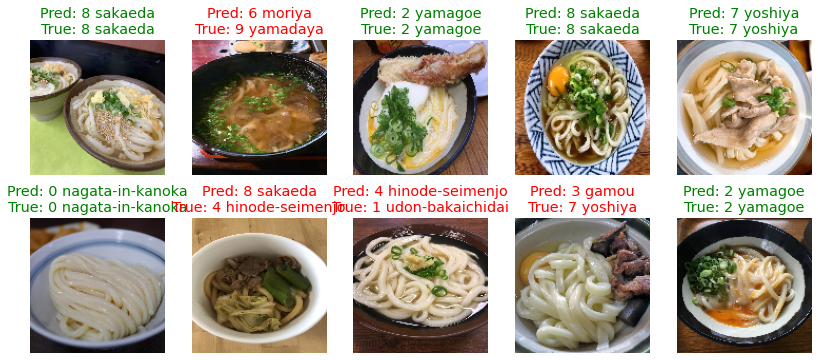

In [19]:
plt.figure(figsize=(14,6))
plt.rcParams["font.size"]=12

for i in range(10):
    plt.subplot(2, 5, i+1)
    img = validX[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
    true_index = validY[i]
    pred_index = predY_valid[i]
   
    if true_index == pred_index:
        color = "green"
    else:
        color = "red"
    
    title = f"Pred: {pred_index} {udonya_list[pred_index]}\nTrue: {true_index} {udonya_list[true_index]}"
    plt.title(title, color=color)    # 推論結果をタイトルとして表示

### モデルの精度を検証
全ての検証用データに対するモデルの精度を統計的に検証します。

In [20]:
score = model.evaluate(validX, validY_onehot)
print(f"Validation Accuracy = {score[1]:.2f}")

16/16 [==============================] - 0s 10ms/step - loss: 0.9360 - accuracy: 0.6940
Validation Accuracy = 0.69


### 混同行列
モデルの精度をより詳しく検証するために混同行列を確認しましょう。

Text(0.5, 38.0, 'Prediction')

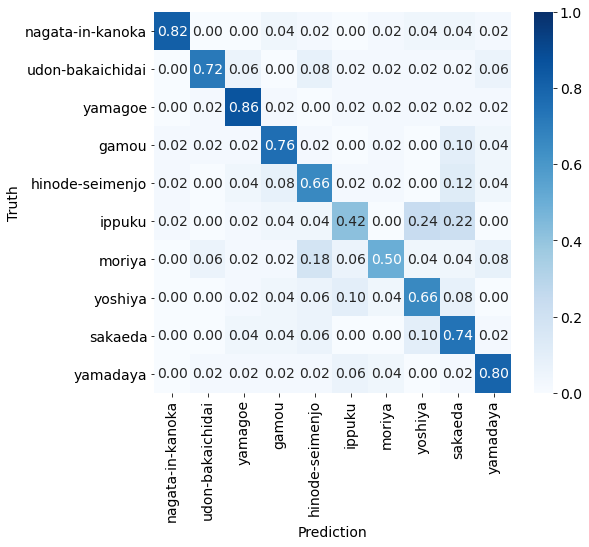

In [21]:
cmx = np.array(confusion_matrix(validY, predY_valid))    # 混同行列confusion matrixを作成

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.rcParams["font.size"]=14
plt.figure(figsize=(8,7))
sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=udonya_list, yticklabels=udonya_list)

plt.ylabel("Truth")
plt.xlabel("Prediction")

## コンペティション

### usernameの設定
```username```に自分の名前を記入してください。

**注意**
* 提出用ファイルとランキングのリストに反映されます。
* 半角英数字のみで記載してください。
* ハンドルネームでも構いません。他の人と同じにならないような名前を考えてください。
* 何回提出しても構いませんが，同じ```username```を使ってください。

In [22]:
username = "USERNAME"

### 提出ファイルの生成
以下のセルを実行して提出するファイルを生成してください。

In [23]:
# 推論結果（確率）が最大となる指標を求める
predY_test_onehot = model.predict(testX)
predY_test = np.argmax(predY_test_onehot, axis=1)

# pandasのDataFrameとして推論結果をまとめる
df = pd.DataFrame()
df["id"] = np.arange(len(predY_test))
df["label"]=predY_test

# 提出用ファイルを保存するパスを指定する。
submission_filename = f"{username}_submission.xlsx"
submission_path = os.path.join(working_dir, submission_filename) 

# 提出用ファイルを保存する
df.to_excel(submission_path, index=False)

### 推論結果のアップロード
以下のGoogleフォームから```username_submission.xlsx```をアップロードしてください。

https://forms.gle/ByhichUApgjkERgM8

### ランキングの確認
現在のランキングはここで確認できます。

https://drive.google.com/file/d/1gxUgeX4JZGarOEli8LuuF1eCrgH8ZM2b/view?usp=sharing